In [87]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tf
import seaborn as sns
import subprocess

In [88]:
res = 1080
dist = '4_5m'
file_name = '16h5'
bags_dir = '/home/uware/rosbags/dynamic/linear/'
vid_dir = '/home/uware/Downloads/test_vids/dynamic/linear/'
bag = rosbag.Bag(bags_dir + dist + '/'+ str(res) + '/'+ file_name + '.bag')
vid_file = vid_dir + dist + '/'+ str(res) + '/'+ file_name + '.mp4'

# create variables
target = 'is_detected'

# target is to be detected at 0.5m/s ( walking speed is about 1.4m/s )
print(dist + '_'+ file_name + '_'+ str(res))

4_5m_16h5_1080


In [89]:
# video length will be used for calculating avr speed
def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)

In [90]:
topic = '/tag_detections'

rows = []
false_positives = []

for topic, msg, t in bag.read_messages(topics=topic):
    time = t.to_sec()
    
    # we only care if there is or there isn't a detection in message published and consider there is only one tag in the frame
    is_detected = len(msg.detections)

    # detection positions are only for information, it is not being used for anything
    if is_detected==1:
        position = msg.detections[0].pose.pose.pose.position
        x,y,z = position.x, position.y, position.z
        row={'time': time, target: is_detected, 'x': x, 'y': y, 'z': z}
    elif is_detected>1: 
        for detection in msg.detections:
            position = detection.pose.pose.pose.position
            # add to datapoints if its within measure distance, meaning avoid fp's
            if 4 < position.z < 5.5:
                x,y,z = position.x, position.y, position.z
                row={'time': time, target: 1, 'x': x, 'y': y, 'z': z}
            else:
                false_positives.append(detection)
    elif is_detected==0:
        row={'time': time, target: is_detected, 'x': None, 'y': None, 'z': None}
    rows.append(row)

df = pd.DataFrame.from_records(rows)
print(len(false_positives))

22


In [91]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df.groupby(target).head()

,is_detected,x,y,z,relative_time
0,1,-2.570290,-0.192837,4.820896,0.000000
1,1,-2.365724,-0.184581,4.807638,0.891704
2,1,-2.060298,-0.173466,4.777513,1.975389
3,1,-1.895053,-0.168349,4.748751,2.695487
4,1,-1.754089,-0.164822,4.723618,3.391838
5,0,NaN,NaN,NaN,4.227115
6,0,NaN,NaN,NaN,4.999274
9,0,NaN,NaN,NaN,7.275667
20,0,NaN,NaN,NaN,12.512247
23,0,NaN,NaN,NaN,13.489774


In [92]:
# ratio of detected to not
ratios = df.is_detected.value_counts(normalize=True)*100
ratios

1    86.624204
0    13.375796
Name: is_detected, dtype: float64

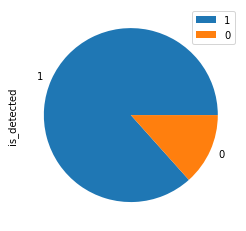

In [93]:
ratios.plot.pie()
plt.legend()

In [94]:
vid_length = get_length(vid_file)
vid_length

11.167

In [95]:
# distance moved
distance = df.x.max() - df.x.min()
distance

6.327535362197194

In [96]:
# velocity in m/s
distance/vid_length

0.5666280435387476

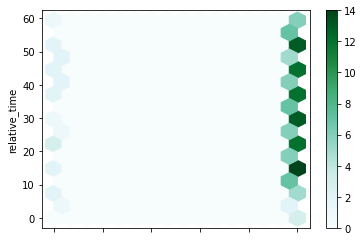

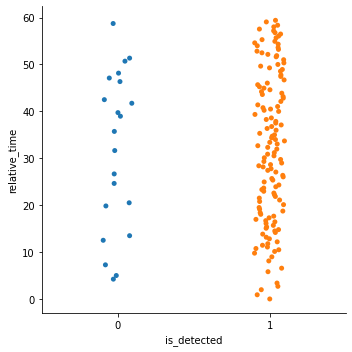

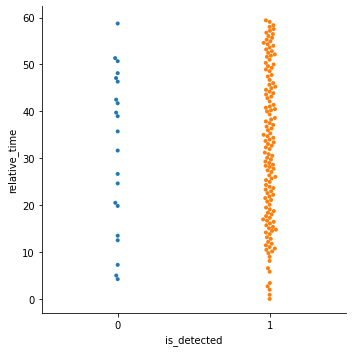

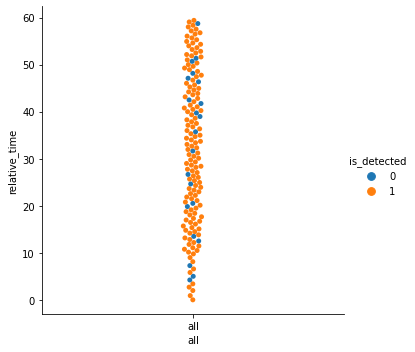

In [97]:
df.plot.hexbin(x=target, y="relative_time", gridsize=15)
sns.catplot(x=target, y='relative_time', data=df)
sns.catplot(x=target, y='relative_time', data=df, kind="swarm", s=4) # s=size of markers causes warnings when >4

# creating a dummy column for plotting both classes together
df.loc[:,'all'] = 'all'
sns.catplot(x='all', y='relative_time', data=df, hue=target, kind="swarm")